In [1]:
from math import ceil, log
from functools import reduce
import re

from scipy.stats import linregress as linear_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.precision", 16)

In [2]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, L, phi=1):
        self.T, self.K, self.Z, self.B, self.E, self.L = int(T), int(K), int(Z), int(B), int(E), int(L)
        self.bpe, self.phi = bpe, phi
        self.is_tiering = True if (K == T - 1) else False
        self.N = self.estimate_N()
        self.mfilt = int(self.bpe * self.N) >> 3
            
    def estimate_N(self):
        num_entries = 0
        for level in range(1, int(self.L) + 1):
            num_entries += (self.B / self.E) * (self.T - 1) * (self.T ** (level - 1))

        return num_entries
        
    def level(self):

        return ceil(log((self.N * self.E) / self.B + 1, self.T))
    
    def write_cost(self):
        cost = self.T * (1 + self.phi) * (self.L / self.B)
        cost /= self.T if self.is_tiering else 2

        return cost
    
    def fp(self, curr_level):
        alpha = (self.T ** (self.T / (self.T - 1))) / (self.T ** (self.L + 1 - curr_level))

        return alpha * (np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N))
    
    def non_empty_read_cost(self):
        cost = 0
        run_probs = [self.B * (self.T ** (i)) / (self.E * self.N) for i in range(0, self.L)]
        fp_levels = [self.fp(i + 1) for i in range(0, self.L)]
        fp_levels_sum = [0] + list(np.cumsum(fp_levels))
        if self.is_tiering:
            for i in range(0, self.L):
                for r in range(1, self.T):
                    cost += run_probs[i] * (1 + (self.T - 1) * fp_levels_sum[i] + (r - 1) * fp_levels[i])
        else:
            for i in range(0 , self.L):
                cost += (self.T - 1) * run_probs[i] * (1 + fp_levels_sum[i])

        return cost
    
    def old_non_empty_read_cost(self):
        cost = 1 + self.empty_read_cost() 
        sub = np.e ** ((-1 * self.mfilt * (np.log(2) ** 2) / (self.N * self.L)) + (1 / (self.L * (self.T - 1))))
        if self.is_tiering:
            sub *= (self.T / (2 * (self.T - 1)))
        cost -= sub

        return cost
    
    def empty_read_cost(self):
        if self.is_tiering:
            alpha = self.T ** (self.T / (self.T - 1))
        else:
            alpha = (self.T ** (self.T / (self.T - 1))) / (self.T - 1)
        beta = np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N)

        return alpha * beta

    def dost_write_cost(self):

        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

In [3]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
#     plt.style.use('fivethirtyeight')

def read_data(file_path, operation='read'): 
    df = pd.read_csv(file_path)
    if operation == 'read':
        df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
        df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)
        df['model_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).empty_read_cost(), axis=1)
        df['measured_non_empty_read_cost'] = df['valid_read_time'] / df['num_reads']
        df['measured_empty_read_cost'] = df['empty_read_time'] / df['num_reads']
    else:
        df['model_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).write_cost(), axis=1)
        df['measured_write_cost'] = df['write_time'] / df['num_writes'] 
    
    return df

In [4]:
def plot_cost_ratio(df, operation='non_empty_read', num_runs=1):
    is_tiering = True if df.iloc[-1]['K'] == df.iloc[-1]['T'] - 1 else False
    fig, ax1 = plt.subplots(figsize=(15,5))
    num_op = 'num_reads' if operation == 'non_empty_read' or operation == 'empty_read' else 'num_writes'
    if operation == 'non_empty_read':
        op_str = 'Non Empty Read'
    elif operation == 'empty_read':
        op_str = 'Empty Read'
    else:
        op_str = 'Writes'

    ax1.set_xlabel('Size Ratio (T)'), ax1.set_ylabel(f'Avg ms per {op_str}', color='black')
    l1 = ax1.plot(df['T'], df[f'measured_{operation}_cost'], 'o--', dashes=(5,1), color='black')
    if num_runs > 1:
        if operation == 'non_empty_read':
            cols = ['valid_read_time_' + str(i) for i in range(num_runs)]
        else:
            cols = [f'{operation}_time_' + str(i) for i in range(num_runs)]
        df[f'{operation}_std'] = df[cols].div(df[num_op], axis=0).std(axis=1)
        ax1.errorbar(df['T'], df[f'measured_{operation}_cost'], yerr=df[f'{operation}_std'], markersize=10, ls='')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(bottom=0)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost', color='red')
    l2 = ax2.plot(df['T'], df[f'model_{operation}_cost'], color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(bottom=0)
    
    E, num_non_empty_reads = df.iloc[-1][['E', num_op]]
    params = ['Entry Size: {} KB'.format(E / (1 << 10))]
    if operation == 'non_empty_read' or operation == 'empty_read':
        ax3 = ax1.twiny()
        ax3.tick_params(axis='x'), ax3.set_xlabel('Buffer Size, Levels'), ax3.set_xlim(ax1.get_xlim()), ax3.set_xticks(df1['T'])
        ax3.set_xticklabels(list(zip(df1['B'].apply(lambda x : f'{x >> 20} MB'), df['L'])))
        params += ['{}:\n{} million (~ {:.2f} GB)'.format(op_str, int(num_non_empty_reads / 1e6), int(num_non_empty_reads) * E / (1 << 30))]
    else:
        ax3 = ax1.twiny()
        ax3.tick_params(axis='x'), ax3.set_xlabel('Levels'), ax3.set_xlim(ax1.get_xlim()), ax3.set_xticks(df['T'])
        ax3.set_xticklabels(df['L'])
        params += [f'Buffer size : {int(df1.iloc[-1]["B"]) >> 20} MB'] 
        
    ax1.text(1.075, 0.35, '\n'.join(params), transform=ax1.transAxes)
    ax1.set_xticks(df['T']), ax1.set_xticklabels(df['T'])
    ax1.legend(l1 + l2, ['Measured', 'Model'], bbox_to_anchor=(1.05, 1), loc=2, ncol=1)
    
    ax1.set_title(f'{op_str} Tiering\n' if is_tiering else f'{op_str} Leveling\n', fontsize=20)
    fig.tight_layout()
    
    return fig

In [5]:
def plot_diff(df1, df2, operation='non_empty_read'):
    fig, ax1 = plt.subplots(figsize=(15,5))
    num_op = 'num_reads' if operation == 'non_empty_read' or operation == 'empty_read' else 'num_writes'
    is_tiering_1 = True if df1.iloc[-1]['K'] == df1.iloc[-1]['T'] - 1 else False
    is_tiering_2 = True if df2.iloc[-1]['K'] == df2.iloc[-1]['T'] - 1 else False
    label1, label2 = 'Tier' if is_tiering_1 else 'Level', 'Tier' if is_tiering_2 else 'Level'
    if operation == 'non_empty_read':
        op_str = 'Non Empty Read'
    elif operation == 'empty_read':
        op_str = 'Empty Read'
    else:
        op_str = 'Writes'
    
    ax1.set_xlabel('Size Ratio (T)'), ax1.set_ylabel(f'Avg ms per {op_str}')
    l1 = ax1.plot(df1['T'], df1[f'measured_{operation}_cost'], 'o--', label=label1)
    l2 = ax1.plot(df2['T'], df2[f'measured_{operation}_cost'], 'o--', label=label2)
    ax1.set_ylim(bottom=0)
    
    E, num_operations = df1.iloc[-1][['E', num_op]]
    params = ['Entry Size: {} KB'.format(E / (1 << 10))]
    if operation == 'non_empty_read' or operation == 'empty_read':
        ax3 = ax1.twiny()
        ax3.tick_params(axis='x'), ax3.set_xlabel('Buffer Size, Levels'), ax3.set_xlim(ax1.get_xlim()), ax3.set_xticks(df1['T'])
        ax3.set_xticklabels(list(zip(df1['B'].apply(lambda x : f'{x >> 20} MB'), df1['L'])))
        params += ['{}:\n{} million (~ {:.2f} GB)'.format(op_str, int(num_operations / 1e6), int(num_operations) * E / (1 << 30))]
    else:
        ax3 = ax1.twiny()
        ax3.tick_params(axis='x'), ax3.set_xlabel('Levels'), ax3.set_xlim(ax1.get_xlim()), ax3.set_xticks(df1['T'])
        ax3.set_xticklabels(df1['L'])
        params += [f'Buffer size : {int(df1.iloc[-1]["B"]) >> 20} MB'] 
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost')
    l3 = ax2.plot(df1['T'], df1[f'model_{operation}_cost'], label=label1)
    l4 = ax2.plot(df2['T'], df2[f'model_{operation}_cost'], label=label2)
    ax2.set_ylim(bottom=0)
    
    lines = l1 + l3 + l2 + l4
    phony = [plt.plot([], marker='', ls='')[0]]*2
    handles = phony[:1] + lines[::2] + phony[1:] + lines[1::2]
    line_labels = [l.get_label() for l in lines]
    labels = ['Measured'] + line_labels[::2] + ['Model'] + line_labels[1::2]
    
    legend = ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, ncol=2)
    for vpack in legend._legend_handle_box.get_children():
        for hpack in vpack.get_children()[:1]:
            hpack.get_children()[0].set_width(0)
            
    ax1.set_xticks(df1['T'])
    ax1.set_xticklabels(df1['T'])
    ax1.text(1.1, 0.35, '\n'.join(params), transform=ax1.transAxes)
    ax1.set_title(f'{op_str} Difference\n', fontsize=20)

    fig.tight_layout()
    return fig 

# Non Empty Reads

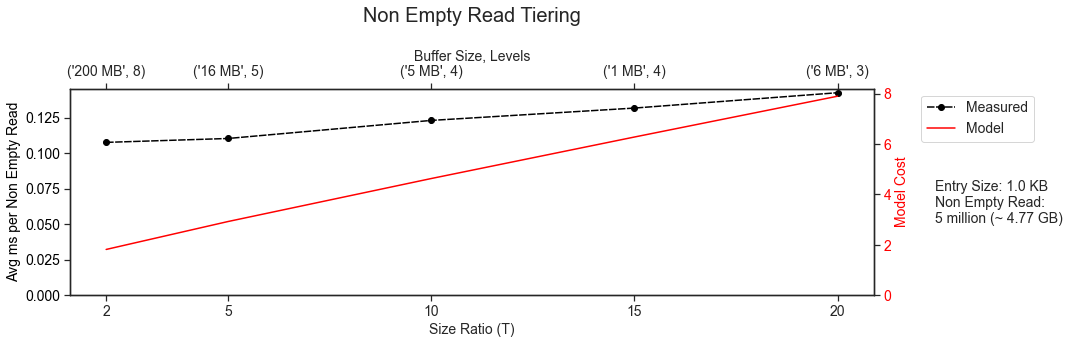

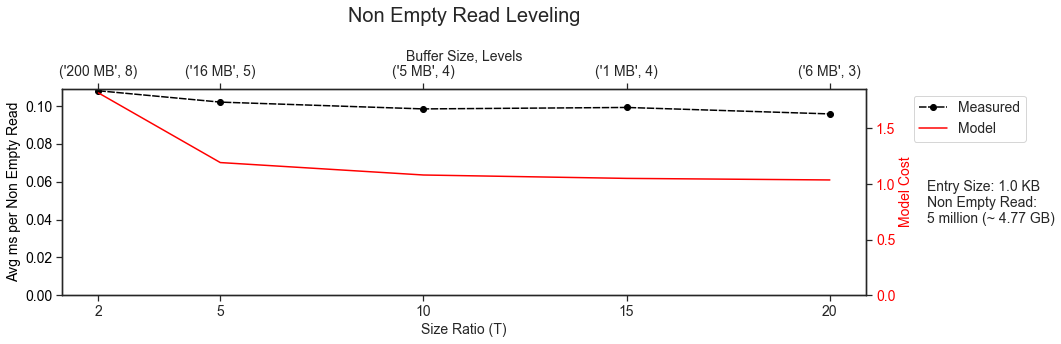

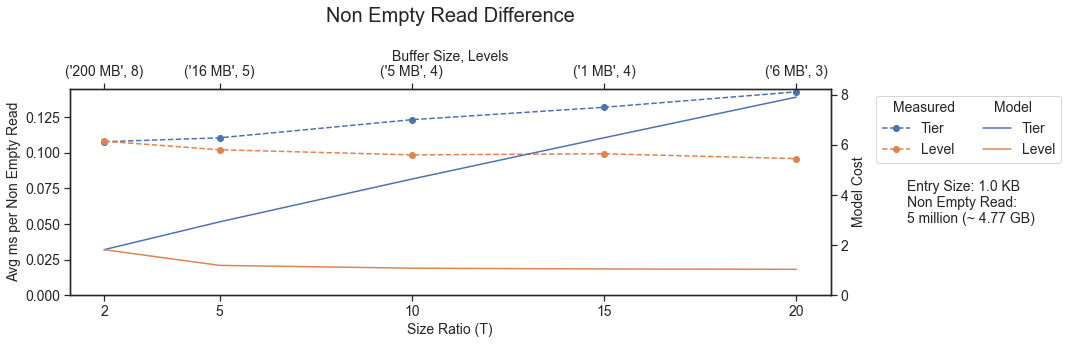

In [6]:
set_style()

df1 = read_data('../../data/read_cost/4.csv', 'read')
_ = plot_cost_ratio(df1, 'non_empty_read', num_runs=5)

df2 = read_data('../../data/read_cost/5.csv', 'read')
_ = plot_cost_ratio(df2, 'non_empty_read', num_runs=5)

_ = plot_diff(df1, df2, 'non_empty_read')

# Empty Reads

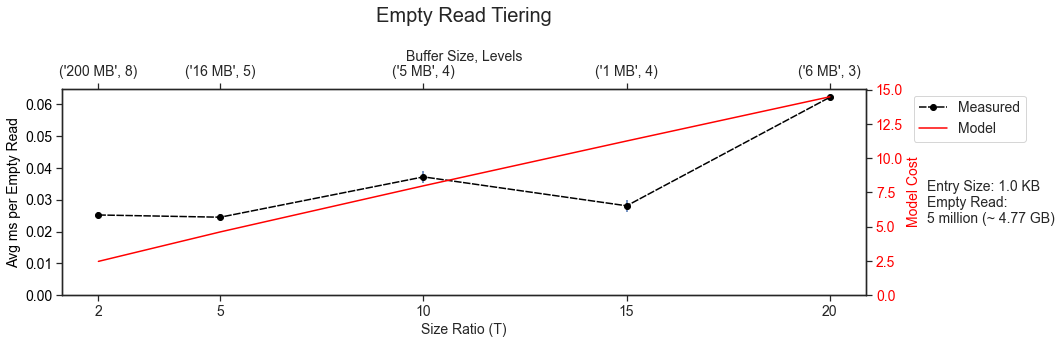

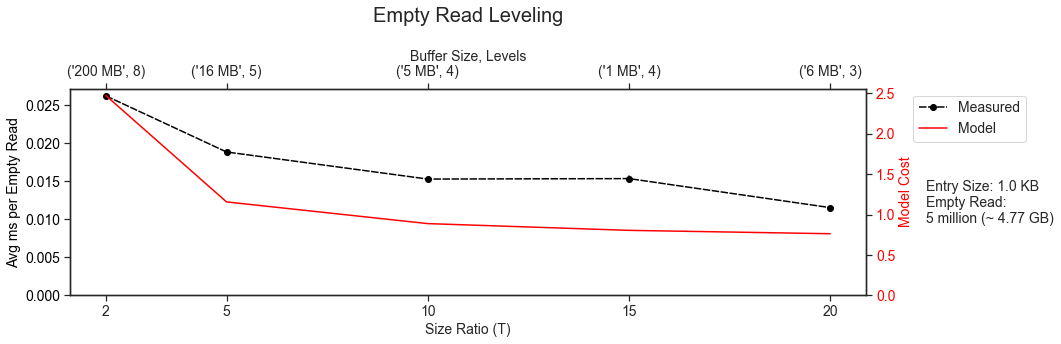

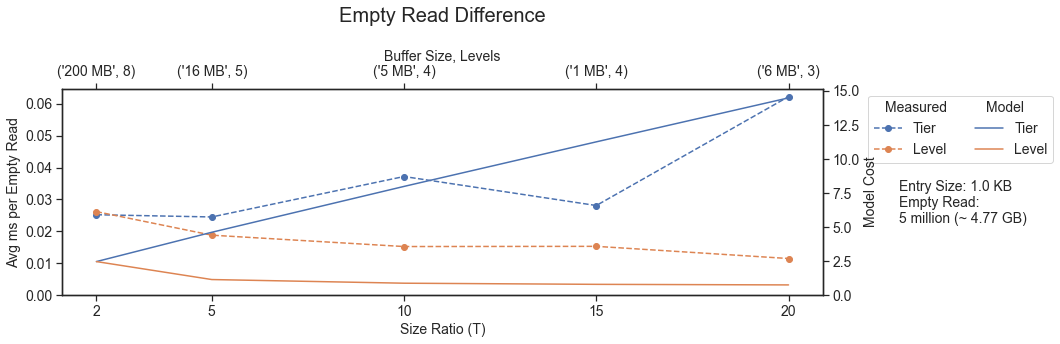

In [7]:
_ = plot_cost_ratio(df1, 'empty_read', num_runs=5)
_ = plot_cost_ratio(df2, 'empty_read', num_runs=5)
_ = plot_diff(df1, df2, 'empty_read')

# Writes

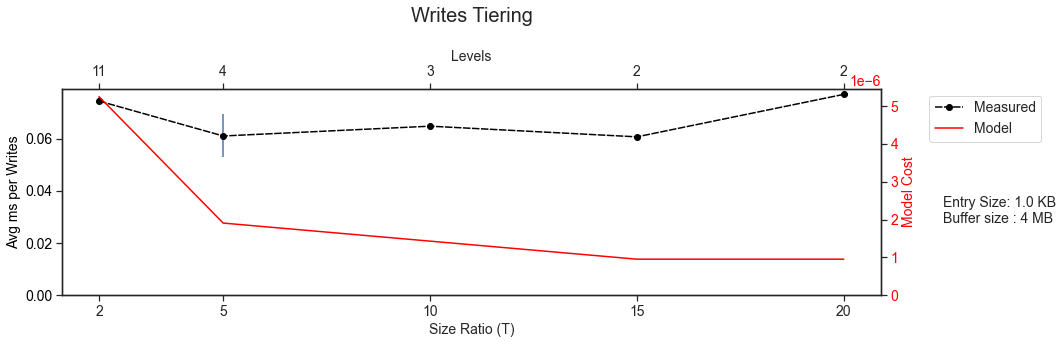

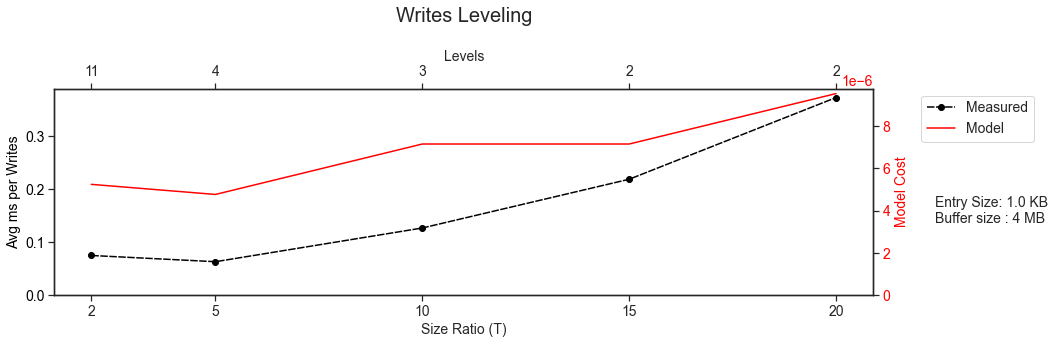

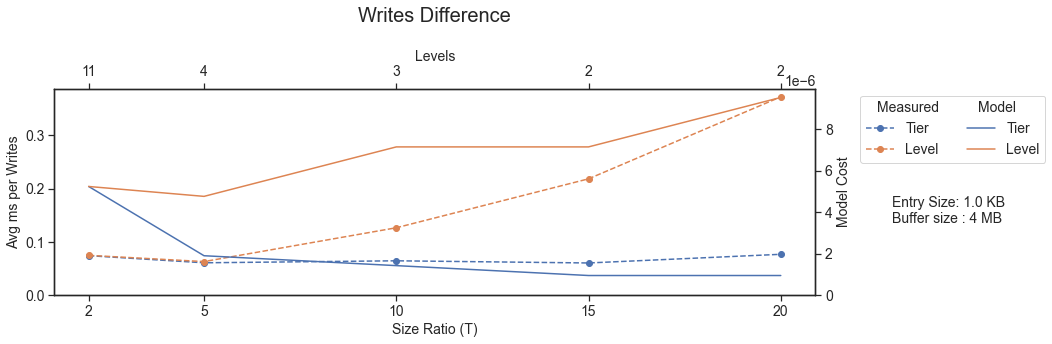

In [8]:
df1 = read_data('../../data/write_cost/3.csv', 'writes')
_ = plot_cost_ratio(df1, operation='write', num_runs=3)

df2 = read_data('../../data/write_cost/4.csv', 'writes')
_ = plot_cost_ratio(df2, operation='write', num_runs=3)

_ = plot_diff(df1, df2, 'write')

In [9]:
df1

,T,L,K,Z,B,E,bpe,num_writes,write_time_0,write_time_1,write_time_2,write_time,model_write_cost,measured_write_cost,write_std
0,2,11,1,1,4194304,1024,8.0,8388608,622270,635997,612364,6.2354366666666651e+05,0.0000052452087402,0.0743321975072225,0.0014147603712525
1,5,4,4,4,4194304,1024,8.0,10240000,606750,715933,550175,6.2428600000000000e+05,0.0000019073486328,0.0609654296875000,0.0082284081357812
2,10,3,9,9,4194304,1024,8.0,36864000,2364035,2371111,2421770,2.3856386666666660e+06,0.0000014305114746,0.0647145905671296,0.0008542219023232
3,15,2,14,14,4194304,1024,8.0,12902400,782192,784558,780204,7.8231800000000000e+05,0.0000009536743164,0.0606335255456349,0.0001689401205337
4,20,2,19,19,4194304,1024,8.0,31129600,2420356,2361201,2399774,2.3937770000000000e+06,0.0000009536743164,0.0768971332750822,0.0009646770342844
